In [2]:
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import seaborn as sns
from scipy.stats import spearmanr
cts = ["ICM-1", "ICM-2", "EPI", "PE", "TE-1", "TE-2", "muralTE", "polarTE"]

# Make AnnData

In [2]:
adata1 = sc.read_h5ad("../08_blastocyst/results/scanpy_processed_gene_based.h5ad")

In [3]:
cts = ["ICM-1", "ICM-2", "EPI", "PE", "TE-1", "TE-2", "muralTE", "polarTE"]
array = []
for ct in cts:
    m = pd.read_csv("../08_blastocyst/results/halflife/%s.gene_based.gene_id.annotated.tsv" % ct, sep="\t", index_col=0)
    m.columns = ["%s.%s" % (c, ct) for c in m.columns]
    array.append(m)
dat = pd.concat(array, axis=1)

a = None
for c in ["Total", "Nascent", "TPM", "TP10K", "NTR", "T", "D", "K"]:
    m = dat[["%s.%s" % (c, ct) for ct in cts]]
    m.columns = cts
    if a is None:
        a = ad.AnnData(m)
    a.layers[c] = m
adata2 = a.T

In [4]:
adata2 = adata2[:,adata2.var.index.isin(adata1.var["GeneID"])]
anno_g = pd.read_csv("../../1_NanoNASCseq/results/assembly_custom/gtf_full/MouseBlastocyst.gtf.gene_info.tsv", sep="\t",index_col=0)
adata2.var = anno_g.loc[adata2.var.index].copy()
adata2.var.insert(0, "GeneID", adata2.var.index)
adata2.var.index = adata2.var["GeneName"]
del adata2.var["GeneName"]

In [7]:
adata2

AnnData object with n_obs × n_vars = 8 × 26549
    var: 'GeneID', 'GeneType', 'Chrom', 'Start', 'End', 'Strand'
    layers: 'Total', 'Nascent', 'TPM', 'TP10K', 'NTR', 'T', 'D', 'K'

In [10]:
adata2.write("results/data.h5ad", compression="gzip")

# Analysis

In [5]:
adata1 = ad.read_h5ad("../10_blastocyst/results/scanpy_processed_gene_based.h5ad")
adata2 = ad.read_h5ad("results/data.h5ad")
anno_g = pd.read_csv("../../1_FLAIRseq/results/assembly_custom/gtf_full/MouseBlastocyst.gtf.gene_info.tsv", sep="\t",index_col=0)

In [35]:
for k, v in sorted(Counter(adata2.var["GeneType"]).items(), key=lambda item: item[1], reverse=True):
    if "pseudo" in k:
        print(v, k, sep="\t")

2371	processed_pseudogene
325	unprocessed_pseudogene
173	transcribed_processed_pseudogene
119	transcribed_unprocessed_pseudogene
23	pseudogene
22	polymorphic_pseudogene
19	transcribed_unitary_pseudogene
18	unitary_pseudogene
2	IG_V_pseudogene
1	translated_unprocessed_pseudogene


In [36]:
gts = ["processed_pseudogene", "unprocessed_pseudogene", "transcribed_processed_pseudogene", "transcribed_unprocessed_pseudogene"]

In [37]:
adata3 = adata2[:, adata2.var["GeneType"].isin(gts)].copy()
adata3

AnnData object with n_obs × n_vars = 8 × 2988
    var: 'GeneID', 'GeneType', 'Chrom', 'Start', 'End', 'Strand'
    layers: 'D', 'K', 'NTR', 'Nascent', 'T', 'TP10K', 'TPM', 'Total'

In [38]:
m = pd.DataFrame(adata3.layers["TP10K"], index=adata3.obs.index.values, columns=adata3.var.index.values).T.fillna(0)
m1 = m[m.max(axis=1) > 0]
print("Total expressed pseudogenes:", len(m1))

vs = []
for ct in m.columns:
    m2 = m[m[ct] > 0]
    print("%s expressed %d pseudogenes." % (ct, len(m2)))
    vs.append(len(m2))
print("Average expressed pseudogenes for each cell-type:", np.mean(vs))

Total expressed pseudogenes: 2596
ICM-1 expressed 1074 pseudogenes.
ICM-2 expressed 1297 pseudogenes.
EPI expressed 1245 pseudogenes.
PE expressed 907 pseudogenes.
TE-1 expressed 896 pseudogenes.
TE-2 expressed 862 pseudogenes.
muralTE expressed 675 pseudogenes.
polarTE expressed 667 pseudogenes.
Average expressed pseudogenes for each cell-type: 952.875


In [39]:
m = pd.DataFrame(adata3.layers["TP10K"], index=adata3.obs.index.values, columns=adata3.var.index.values).T.fillna(0)
m = m[m.max(axis=1) >= 1]
print(len(m))

46


In [41]:
tmp = m.copy()
tmp.index.name = None
tmp.columns = [None] * tmp.shape[1]
ret = sns.clustermap(tmp, z_score=0, cmap="coolwarm", vmin=-2, vmax=2, 
                     col_cluster=False, figsize=(3, 9), 
                     lw=0.5, linecolor="black",
                     cbar_pos=(0.68, 0.92, 0.05, 0.06), cbar_kws=dict(label="z-score"),
                     dendrogram_ratio=[0.15, 0.08])
ax = ret.ax_heatmap
ax.xaxis.tick_top()
plt.sca(ax)
plt.xticks(np.arange(tmp.shape[1]) + 0.5, m.columns, rotation=90)
plt.yticks(np.arange(len(tmp)) + 0.5, ret.data2d.index, fontstyle="italic")
ret.fig.savefig("figures/clustermap_of_pseudogenes.pdf")

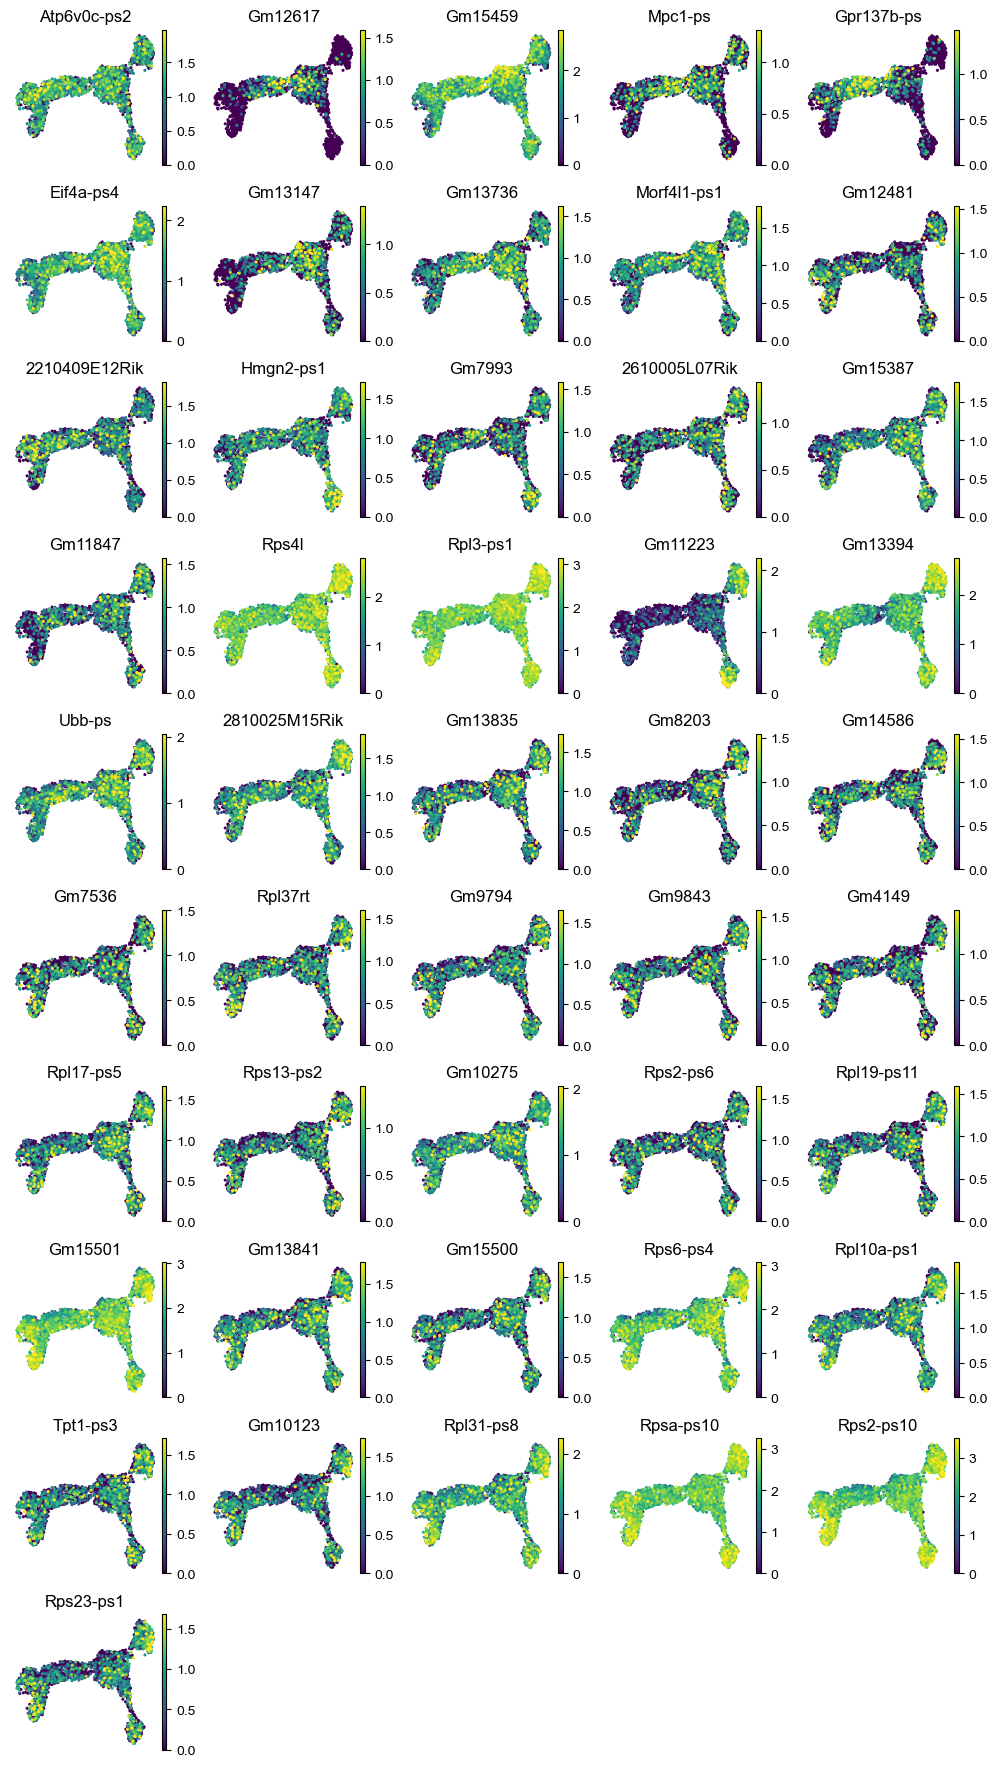

In [9]:
genes = list(ret.data2d.index)
with plt.rc_context({"figure.figsize": (2, 2)}):
    fig = sc.pl.umap(adata1, color=genes, s=20, frameon=False, ncols=5, vmax="p99", wspace=0.2, hspace=0.3)

Mpc1-ps	processed_pseudogene
Gpr137b-ps	processed_pseudogene
Hmgn2-ps1	processed_pseudogene
Gm11223	processed_pseudogene


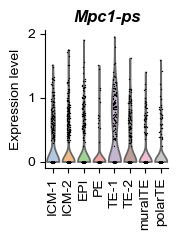

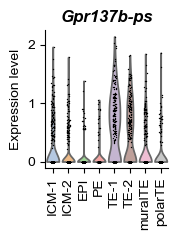

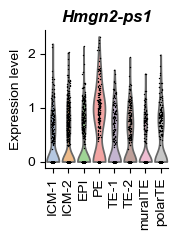

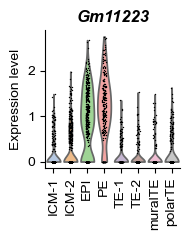

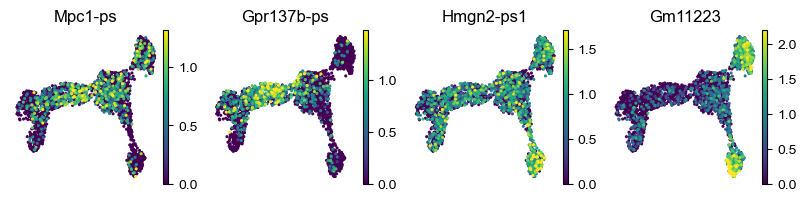

In [43]:
# celltype-specific pseudogenes
# genes = ["Gm12617", "Gm13147", "Gm11223", "Gm13394"]
genes = ["Mpc1-ps", "Gpr137b-ps", "Hmgn2-ps1", "Gm11223"]
for gname in genes:
    gt = anno_g[anno_g["GeneName"] == genes[0]]["GeneType"].values[0]
    print(gname, gt, sep="\t")
with plt.rc_context({"figure.figsize": (2, 2)}):
    fig = sc.pl.umap(adata1, color=genes, s=20, frameon=False, ncols=5, vmax="p99", wspace=0.2, hspace=0.3, save="_of_pseudogenes.pdf")
for i, gname in enumerate(genes):
    plt.figure(figsize=(2, 2.5))
    plt.title(gname, fontstyle="italic", fontweight="bold")
    sc.pl.violin(adata1, gname, groupby="CellType", ax=plt.gca(), show=False, order=m.columns)
    plt.xticks(rotation=90)
    plt.xlabel(None)
    plt.ylabel("Expression level")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.tight_layout()
    plt.savefig("figures/violin_%s.pdf" % gname)

Ubb	True	Ubb-ps
Rpsa	True	Rpsa-ps10
Rpl31	True	Rpl31-ps8
Rps13	True	Rps13-ps2
Hmgn2	True	Hmgn2-ps1
Atp6v0c	True	Atp6v0c-ps2
Rpl19	True	Rpl19-ps11
Rps6	True	Rps6-ps4
Rpl17	True	Rpl17-ps5
Tpt1	True	Tpt1-ps3
Rpl3	True	Rpl3-ps1
Rpl10a	True	Rpl10a-ps1
Mpc1	True	Mpc1-ps
Rps2	True	Rps2-ps10
Rps2	True	Rps2-ps6
Gpr137b	True	Gpr137b-ps
Rps23	True	Rps23-ps1
Eif4a	False	Eif4a-ps4
Morf4l1	True	Morf4l1-ps1


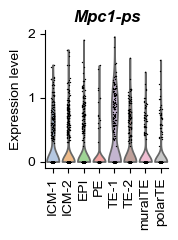

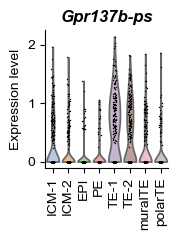

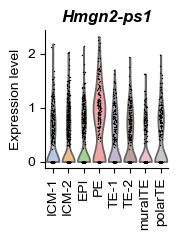

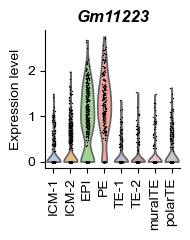

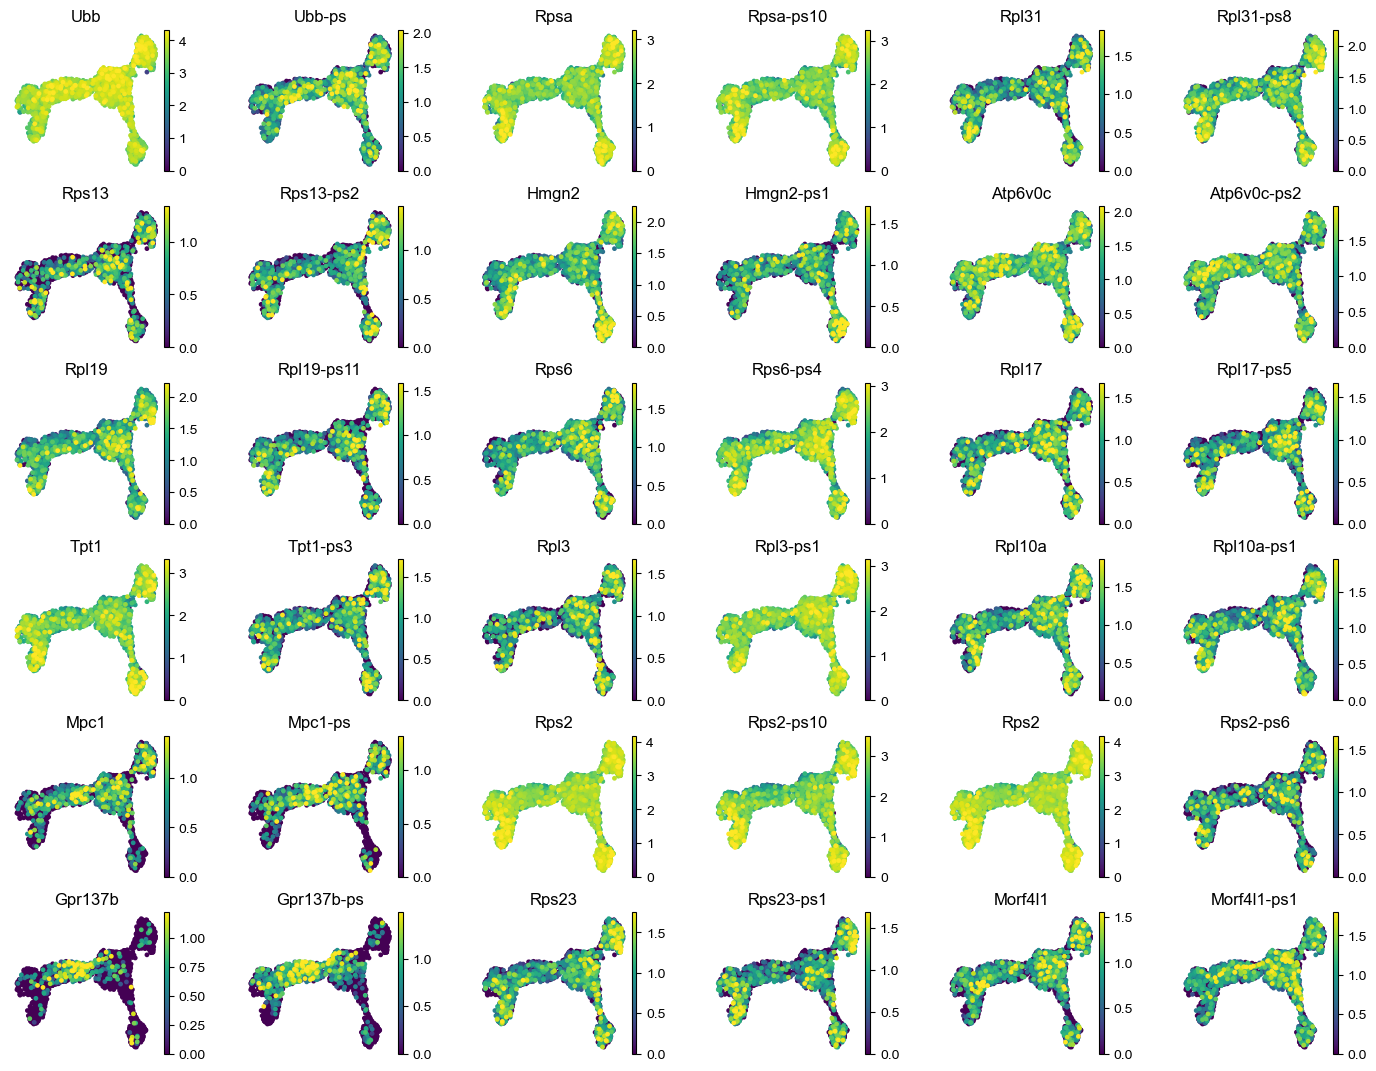

In [44]:
# parent - pseudo genes
genes = []
for gname in m.index:
    if "-ps" in gname:
        pgname = gname.split("-")[0]
        gt = anno_g[anno_g["GeneName"] == gname]["GeneType"].values[0]
        print(pgname, pgname in anno_g["GeneName"].values, gname, sep="\t")
        if pgname in anno_g["GeneName"].values:
            pgt = anno_g[anno_g["GeneName"] == pgname]["GeneType"].values[0]
            genes.append(pgname)
            genes.append(gname)
with plt.rc_context({"figure.figsize": (2, 2)}):
    fig = sc.pl.umap(adata1, color=genes, ncols=6, vmax="p99", frameon=False)

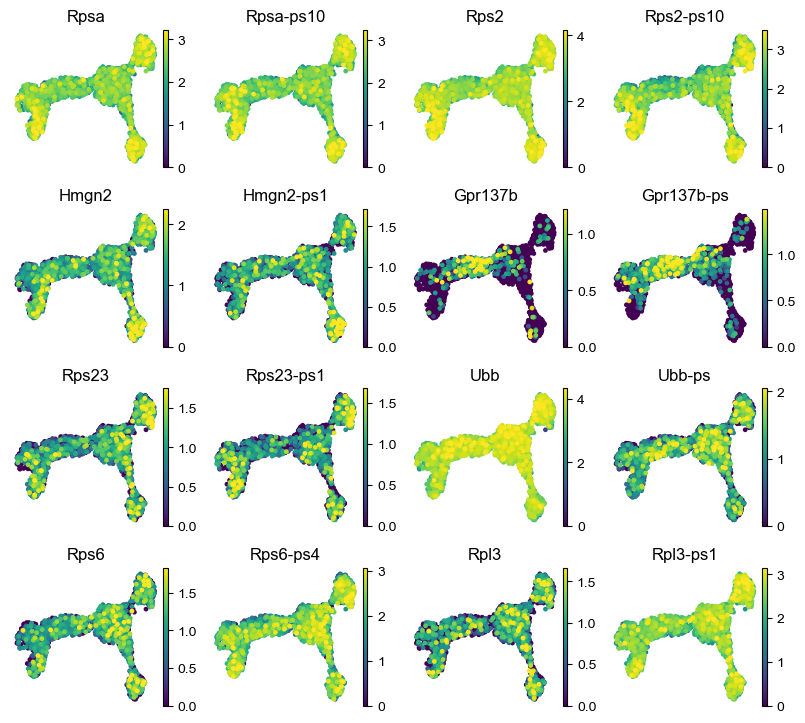

In [44]:
genes = [
    "Rpsa", "Rpsa-ps10",
    "Rps2", "Rps2-ps10",
    "Hmgn2", "Hmgn2-ps1", 
    "Gpr137b", "Gpr137b-ps",
    "Rps23", "Rps23-ps1",
    "Ubb", "Ubb-ps", 
    "Rps6", "Rps6-ps4",
    "Rpl3", "Rpl3-ps1",
]
with plt.rc_context({"figure.figsize": (2, 2)}):
    fig = sc.pl.umap(adata1, color=genes, frameon=False, ncols=4, vmax="p99", wspace=0.2, hspace=0.3)

In [45]:
genes = [
    "Ubb", "Ubb-ps", 
    "Rps6", "Rps6-ps4",
    "Rpl3", "Rpl3-ps1", 
    "Gpr137b", "Gpr137b-ps"
]

for i in range(int(len(genes)/2)):
    fig, axs = plt.subplots(1, 2, figsize=(4, 2.5), sharex=True, sharey=True)
    gene1, gene2 = genes[i * 2], genes[i * 2 + 1]
    for j in range(2):
        gene = genes[i * 2 + j]
        ax = axs[j]
        plt.sca(ax)
        if j == 0:
            title = "%s (parent)" % gene
        else:
            title = "%s (pseudo)" % gene
        plt.title(title, fontstyle="italic", fontweight="bold")
        sc.pl.violin(adata1, gene, groupby="CellType", ax=plt.gca(), show=False, order=m.columns)
        plt.xticks(rotation=90)
        plt.xlabel(None)
        if j == 0:
            plt.ylabel("Expression level")
        plt.gca().spines["top"].set_visible(False)
        plt.gca().spines["right"].set_visible(False)
    plt.tight_layout()
    plt.savefig("figures/violin_parent_pseudogene_%s.pdf" % gene1)

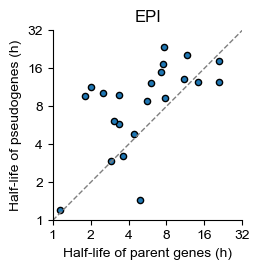

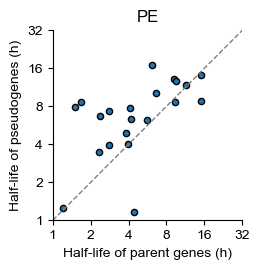

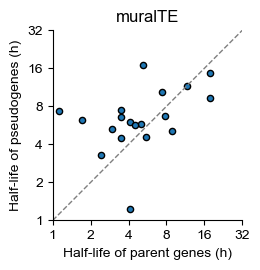

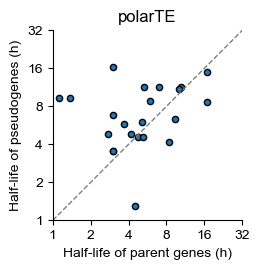

In [70]:
for ct in ["EPI", "PE", "muralTE", "polarTE"]:
    m = pd.DataFrame(adata3.layers["TP10K"], index=adata3.obs.index.values, columns=adata3.var.index.values).T.fillna(0)
    m = m[m[ct] > 0.5]

    rows = []
    for gname in m.index:
        if "-ps" in gname:
            pgname = gname.split("-")[0]
            if pgname in anno_g["GeneName"].values:
                g1, g2 = pgname, gname
                e1 = adata2[adata2.obs.index == ct, adata2.var.index == g1].layers["TP10K"][0][0]
                e2 = adata2[adata2.obs.index == ct, adata2.var.index == g2].layers["TP10K"][0][0]
                if e1 < 0.5 or e2 < 0.5:
                    continue
                t1 = adata2[adata2.obs.index == ct, adata2.var.index == g1].layers["T"][0][0]
                t2 = adata2[adata2.obs.index == ct, adata2.var.index == g2].layers["T"][0][0]
                rows.append(["%s, %s" % (g1, g2), t1, t2])
    d = pd.DataFrame(rows, columns=["Genes", "T.1", "T.2"])
    
    xs, ys = d["T.1"], d["T.2"]
    xs, ys = np.log2(xs), np.log2(ys)
    lim = 5
    plt.figure(figsize=(2.7, 2.8))
    plt.title(ct)
    plt.scatter(xs, ys, marker="o", s=20, edgecolor="black", )
    plt.plot([0, lim], [0, lim], lw=1, ls="--", color="C7")
    plt.xlim(0, lim)
    plt.ylim(0, lim)
    xs0 = np.arange(lim + 1)
    ticks = list(map(str, [2**x for x in xs0]))
    plt.xticks(xs0, ticks)
    plt.yticks(xs0, ticks)
    plt.xlabel("Half-life of parent genes (h)")
    plt.ylabel("Half-life of pseudogenes (h)")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.tight_layout()
    plt.savefig("figures/scatter_halflife_of_paired_pseudogene.%s.pdf" % ct)

# Report

In [3]:
df = pd.read_csv("/home/chenzonggui/species/mus_musculus/GRCm38.p6/gencode.vM25.genes.tsv", sep="\t")
tmp = pd.read_csv("results/Mus_musculus.GRCm39.112.chr.gff3.tsv", sep="\t")
descriptions = dict()
for v1, v2 in tmp[["ID", "description"]].values:
    if isinstance(v1, str):
        descriptions[v1] = v2
df["Description"] = [descriptions.get("gene:%s" % x.split(".")[0]) for x in df["GeneID"]]

/home/chenzonggui/tmp/ipykernel_17861/3191740097.py:2: DtypeWarning: Columns (0,9) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv("results/Mus_musculus.GRCm39.112.chr.gff3.tsv", sep="\t")


In [4]:
df1 = df[["pseudo" in x for x in df["GeneType"]]].copy()
print("No. of GeneID:", len(set(df1["GeneID"])))
print("No. of GeneName:", len(set(df1["GeneName"])))

No. of GeneID: 13743
No. of GeneName: 13733


In [5]:
counter = Counter(df1["GeneType"])
for k, v in sorted(counter.items()):
    print(v, k, sep="\t")

1	IG_C_pseudogene
3	IG_D_pseudogene
158	IG_V_pseudogene
2	IG_pseudogene
10	TR_J_pseudogene
34	TR_V_pseudogene
89	polymorphic_pseudogene
10002	processed_pseudogene
61	pseudogene
300	transcribed_processed_pseudogene
26	transcribed_unitary_pseudogene
271	transcribed_unprocessed_pseudogene
2	translated_unprocessed_pseudogene
61	unitary_pseudogene
2723	unprocessed_pseudogene


In [6]:
gname2gid = defaultdict(list)
for gid, gname in df[["GeneID", "GeneName"]].values:
    gname2gid[gname].append(gid)

gids = []
gnames = []
for x in df1["GeneName"]:
    gname = None
    gid = None
    if "-ps" in x:
        gname = x.split("-ps")[0]
        gid = gname2gid[gname]
        if len(gid) == 0:
            gid = None
            gname = None
        elif len(gid) == 1:
            gid = gid[0]
        else:
            gid = list(sorted(gid))[0]
        if gid is None:
            gname = None
    gids.append(gid)
    gnames.append(gname)

df1["ParentID"] = gids
df1["ParentName"] = gnames

In [7]:
adata2 = ad.read_h5ad("results/data.h5ad")
m = pd.DataFrame(adata2.layers["TP10K"], index=adata2.obs.index.values, columns=adata2.var.index.values).T.fillna(0)
cts = list(m.columns)

In [8]:
df2 = df1.merge(m, left_on="GeneName", right_index=True, how="left")
for ct in cts:
    df2["Pseudogene.%s" % ct] = df2[ct].fillna(0)
    del df2[ct]
df2["Pseudogene.TP10K"] = df2[["Pseudogene.%s" % ct for ct in cts]].max(axis=1)

In [9]:
df3 = df2.merge(m, left_on="ParentName", right_index=True, how="left")
for ct in cts:
    df3["Parent.%s" % ct] = df3[ct].fillna(0)
    del df3[ct]
df3["Parent.TP10K"] = df3[["Parent.%s" % ct for ct in cts]].max(axis=1)

In [10]:
columns1 = ["Pseudogene.%s" % ct for ct in cts]
columns2 = ["Parent.%s" % ct for ct in cts]
rs = []
ps = []
for vs1, vs2 in zip(df3[columns1].values, df3[columns2].values):
    ret = spearmanr(vs1, vs2)
    r, p = ret[0], ret[1]
    rs.append(r)
    ps.append(p)
df3["Spearman"] = rs
df3["Spearman_pval"] = ps

/home/chenzonggui/tmp/ipykernel_17861/2763568864.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  ret = spearmanr(vs1, vs2)


Gene numbers: 39 4


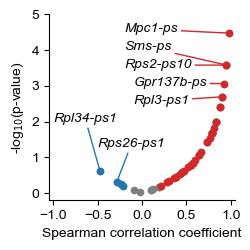

In [11]:
cutoff = 0.1
tmp = df3[(df3["Pseudogene.TP10K"] >= cutoff) & (df3["Parent.TP10K"] >= cutoff)]
tmp = tmp.sort_values(by="Spearman")
xs = tmp["Spearman"]
ys = tmp["Spearman_pval"]
ys = -np.log10(ys)
flags = xs > 0.2
xs1, ys1 = xs[flags], ys[flags]
flags = xs < -0.2
xs2, ys2 = xs[flags], ys[flags]
print("Gene numbers:", len(xs1), len(xs2))
plt.figure(figsize=(2.6, 2.6))
plt.scatter(xs, ys, marker="o", s=20, color="C7")
plt.scatter(xs1, ys1, marker="o", s=20, color="C3")
plt.scatter(xs2, ys2, marker="o", s=20, color="C0")
plt.xlim(-1.05, 1.05)
plt.ylim(-0.2, 5)
genes = ["Rpl34-ps1", "Rps26-ps1", "Rpl3-ps1", "Gpr137b-ps", "Rps2-ps10", "Sms-ps", "Mpc1-ps"]
coords = {
    "Rpl34-ps1": [-1, 2, "C0"],
    "Rps26-ps1": [-0.5, 1.3, "C0"],
    "Rpl3-ps1": [-0.1, 2.5, "C3"], 
    "Gpr137b-ps": [-0.1, 3.0, "C3"],
    "Rps2-ps10": [-0.2, 3.5, "C3"], 
    "Sms-ps": [-0.2, 4, "C3"], 
    "Mpc1-ps": [-0.2, 4.5, "C3"]
}
for gene in genes:
    row = tmp[tmp["GeneName"] == gene]
    g1 = row["GeneName"].values[0]
    g2 = row["ParentName"].values[0]
    x, y = row["Spearman"].values[0], row["Spearman_pval"].values[0]
    y = -np.log10(y)
    ax = plt.gca()
    x1, y1, c = coords[gene]
    with plt.rc_context({"font.style": "italic"}):
        ax.annotate(g1, xy=(x, y), 
                xytext=(x1, y1), 
                arrowprops=dict(arrowstyle="-", shrinkA=0.5, shrinkB=0.5, color=c))
plt.xlabel("Spearman correlation coefficient")
plt.ylabel("-log$_{10}$(p-value)")
plt.xticks(np.arange(-1, 1.1, 0.5))
for loc in ["top", "right"]:
    plt.gca().spines[loc].set_visible(False)
plt.tight_layout()
plt.savefig("figures/spearman_with_parent_gene_expression.pdf")
plt.show()

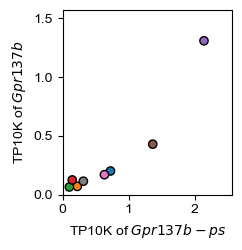

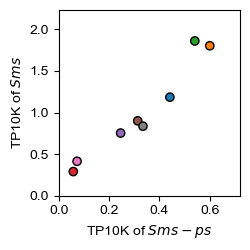

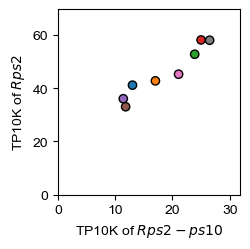

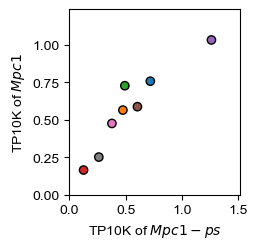

In [12]:
tmp1 = tmp.sort_values(by="Spearman").tail(4)
columns1 = ["Pseudogene.%s" % ct for ct in cts]
columns2 = ["Parent.%s" % ct for ct in cts]
for gname, pname, vs1, vs2 in zip(tmp1["GeneName"], tmp1["ParentName"], tmp1[columns1].values, tmp1[columns2].values):
    plt.figure(figsize=(2.6, 2.6))
    # plt.title("$\it{%s}$" % gname)
    plt.scatter(vs1, vs2, edgecolor="black", color=["C%d" % i for i in range(8)])
    plt.xlim(0, max(vs1) * 1.2)
    plt.ylim(0, max(vs2) * 1.2)
    plt.xlabel("TP10K of $\it{%s}$" % gname)
    plt.ylabel("TP10K of $\it{%s}$" % pname)
    plt.tight_layout()
    plt.savefig("figures/scatter_pseudogene_parentgene.%s.pdf" % gname)
    plt.show()
    plt.close()

In [13]:
cts

['ICM-1', 'ICM-2', 'EPI', 'PE', 'TE-1', 'TE-2', 'muralTE', 'polarTE']

In [14]:
df4 = df3.copy()
del df4["TranscriptID"]
del df4["TranscriptType"]
del df4["Canonical"]
df4.to_csv("results/pseudogene_info.tsv", sep="\t", index=False)

In [16]:
df = pd.read_csv("results/pseudogene_info.tsv", sep="\t", index_col=0)

In [17]:
d = df[(df["Pseudogene.TP10K"] > 10) & (df["Parent.TP10K"] > 0) & (df["Parent.TP10K"] < 10)]
d = d.sort_values(by="Pseudogene.TP10K")
d

,GeneType,GeneName,Chrom,Start,End,Strand,Length,Description,ParentID,ParentName,...,Parent.ICM-2,Parent.EPI,Parent.PE,Parent.TE-1,Parent.TE-2,Parent.muralTE,Parent.polarTE,Parent.TP10K,Spearman,Spearman_pval
GeneID,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000081406.4,processed_pseudogene,Rps6-ps4,chr2,75191072,75191822,-,750,"ribosomal protein S6, pseudogene 4 [Source:MGI...",ENSMUSG00000028495.14,Rps6,...,1.873783,1.764409,2.051429,1.618100,1.434612,0.937519,1.692772,2.051429,0.214286,0.610344
ENSMUSG00000084349.3,processed_pseudogene,Rpl3-ps1,chrX,13202570,13203780,+,1210,"ribosomal protein L3, pseudogene 1 [Source:MGI...",ENSMUSG00000060036.14,Rpl3,...,1.212187,1.296301,1.267628,0.801118,0.847989,0.864465,1.138964,1.296301,0.904762,0.002008


Counter({'processed_pseudogene': 138, 'transcribed_processed_pseudogene': 13, 'transcribed_unprocessed_pseudogene': 6, 'unprocessed_pseudogene': 3, 'pseudogene': 1})


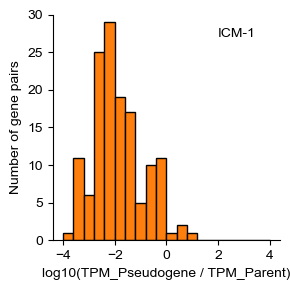

Counter({'processed_pseudogene': 158, 'transcribed_processed_pseudogene': 16, 'transcribed_unprocessed_pseudogene': 5, 'unprocessed_pseudogene': 3})


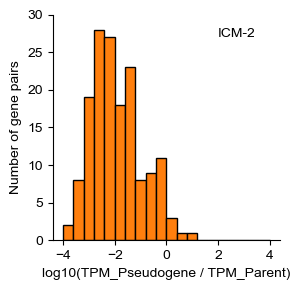

Counter({'processed_pseudogene': 155, 'transcribed_processed_pseudogene': 13, 'transcribed_unprocessed_pseudogene': 5, 'unprocessed_pseudogene': 2, 'pseudogene': 1})


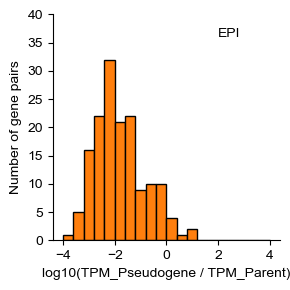

Counter({'processed_pseudogene': 125, 'transcribed_processed_pseudogene': 12, 'transcribed_unprocessed_pseudogene': 3, 'unprocessed_pseudogene': 2})


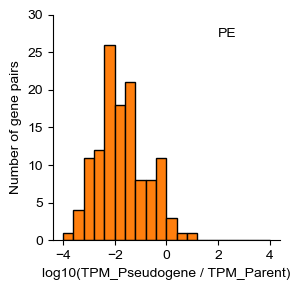

Counter({'processed_pseudogene': 128, 'transcribed_processed_pseudogene': 13, 'transcribed_unprocessed_pseudogene': 4, 'unprocessed_pseudogene': 2})


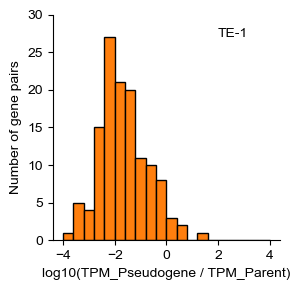

Counter({'processed_pseudogene': 122, 'transcribed_processed_pseudogene': 11, 'transcribed_unprocessed_pseudogene': 4, 'unprocessed_pseudogene': 3})


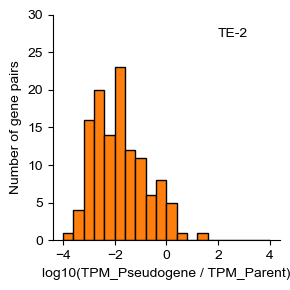

Counter({'processed_pseudogene': 111, 'transcribed_processed_pseudogene': 11, 'transcribed_unprocessed_pseudogene': 4, 'pseudogene': 1, 'unprocessed_pseudogene': 1})


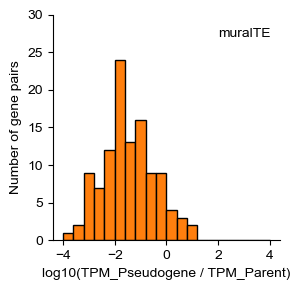

Counter({'processed_pseudogene': 113, 'transcribed_processed_pseudogene': 10, 'transcribed_unprocessed_pseudogene': 3, 'unprocessed_pseudogene': 2, 'pseudogene': 1})


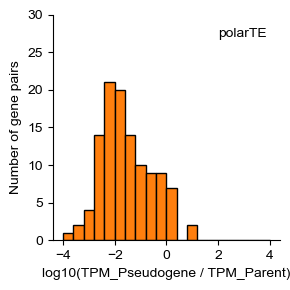

In [18]:
for ct in cts:
    d = df[(df["Pseudogene.%s" % ct] > 0) & (df["Parent.%s" % ct] > 0)]
    print(Counter(d["GeneType"]))
    d = d[d["GeneType"] == "processed_pseudogene"]
    vs = d["Pseudogene.%s" % ct] / d["Parent.%s" % ct]
    vs = np.log10(vs)
    plt.figure(figsize=(3, 3))
    ret = plt.hist(vs, range=(-4, 4), bins=20, edgecolor="black", color="C1")
    
    plt.xlabel("log10(TPM_Pseudogene / TPM_Parent)")
    plt.ylabel("Number of gene pairs")
    ylim = (max(ret[0])//10 + 1) * 10
    plt.ylim(0, ylim)
    plt.text(2, ylim * 0.9, ct)
    for loc in ["top", "right"]:
        plt.gca().spines[loc].set_visible(False)
    plt.tight_layout()
    plt.show()
    # break